In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchlens

# Device configuration
# I am using a Mac M3 chip, so I can't use CUDA, but if you are on nvidia, change this to CUDA
device = torch.device("mps")

In [16]:
# with a large batch size, the optimizer needs a faster learning rate to converge properly. 
num_epochs = 100
batch_size = 1024
learning_rate = 0.004

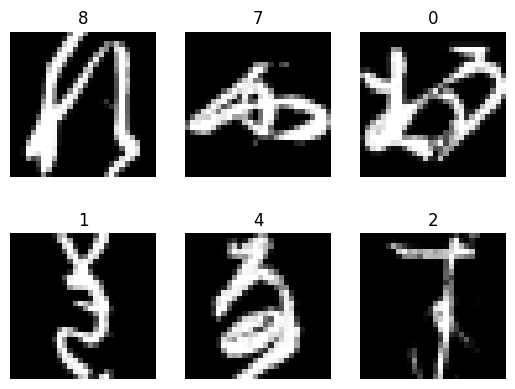

In [17]:
# KMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# visualize some of the data
examples = iter(train_loader)
example_data, example_targets = next(examples)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.title(example_targets[i].item())
    plt.axis('off')
    plt.imshow(example_data[i][0], cmap='gray')

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


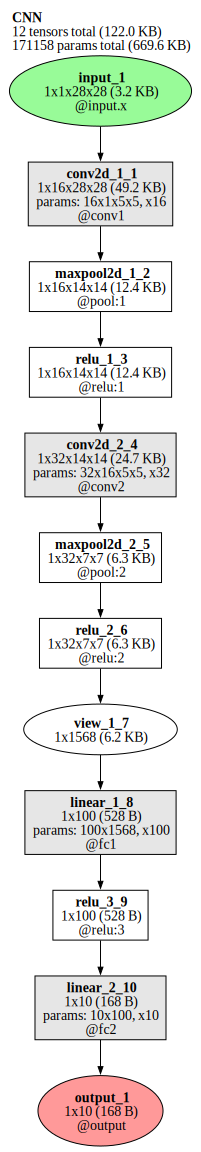

Log of CNN forward pass:
	Random seed: 1547796756
	Time elapsed: 0.911s (0.91s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- no branching
		- no conditional (if-then) branching
		- 6 total modules
	Tensor info:
		- 12 total tensors (122.0 KB) computed in forward pass.
		- 12 tensors (122.0 KB) with saved activations.
	Parameters: 4 parameter operations (171158 params total; 669.6 KB)
	Module Hierarchy:
		conv1
		pool:1
		relu:1
		conv2
		pool:2
		relu:2
		fc1
		relu:3
		fc2
	Layers (all have saved activations):
		  (0) input_1 
		  (1) conv2d_1_1 
		  (2) maxpool2d_1_2 
		  (3) relu_1_3 
		  (4) conv2d_2_4 
		  (5) maxpool2d_2_5 
		  (6) relu_2_6 
		  (7) view_1_7 
		  (8) linear_1_8 
		  (9) relu_3_9 
		  (10) linear_2_10 
		  (11) output_1 


In [18]:
# make a cnn model with 2 convolutional layers and 2 fully connected layers
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = CNN().to(device)

x = torch.randn(1, 1, 28, 28).to(device)
y = model(x)
print(model)

model_history = torchlens.log_forward_pass(model, x, layers_to_save='all', vis_opt='unrolled', vis_direction='topdown')
print(model_history)

In [19]:
# early_stopping.py

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [20]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=learning_rate, decoupled_weight_decay=True)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=10, verbose=True)

 # to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
    

# Training loop
for epoch in range(num_epochs):
    
    # Train the model
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #capture loss
        train_losses.append(loss.item())

    # Validate the model
    model.eval()
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            output = model(test_images)
            loss = criterion(output, test_labels)
            valid_losses.append(loss.item())
    
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    # print training/validation statistics
    epoch_len = len(str(num_epochs))
        
    print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)
    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
    
    if early_stopping.early_stop: 
        print("Early stopping")
        break
    scheduler.step()


[  0/100] train_loss: 1.54632 valid_loss: 1.22962
Validation loss decreased (inf --> 1.229623).  Saving model ...
[  1/100] train_loss: 0.56036 valid_loss: 0.78938
Validation loss decreased (1.229623 --> 0.789378).  Saving model ...
[  2/100] train_loss: 0.33684 valid_loss: 0.56416
Validation loss decreased (0.789378 --> 0.564156).  Saving model ...
[  3/100] train_loss: 0.22211 valid_loss: 0.46703
Validation loss decreased (0.564156 --> 0.467034).  Saving model ...
[  4/100] train_loss: 0.16952 valid_loss: 0.42580
Validation loss decreased (0.467034 --> 0.425798).  Saving model ...
[  5/100] train_loss: 0.14060 valid_loss: 0.41881
Validation loss decreased (0.425798 --> 0.418813).  Saving model ...
[  6/100] train_loss: 0.11646 valid_loss: 0.34192
Validation loss decreased (0.418813 --> 0.341916).  Saving model ...
[  7/100] train_loss: 0.09973 valid_loss: 0.30559
Validation loss decreased (0.341916 --> 0.305586).  Saving model ...
[  8/100] train_loss: 0.08837 valid_loss: 0.29772
Val

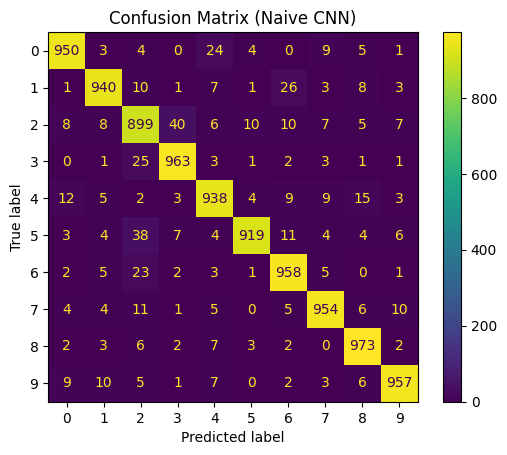

Model Architecture:
CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)

Model Evaluation:
Accuracy: 0.9451

Hyperparameters:
Learning Rate: 0.004
Batch Size: 1024
Number of Epochs: 100


In [23]:
# Evaluation and confusion matrix
model.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
cm_display.plot()
plt.title("Confusion Matrix (Naive CNN)")
plt.show()

# Model summary of accuracy and hyperparameters
print("Model Architecture:")
print(model)
print("\nModel Evaluation:")
print(f"Accuracy: {np.mean(np.array(y_true) == np.array(y_pred))}")
print("\nHyperparameters:")
print(f"Learning Rate: {learning_rate}")
print(f"Batch Size: {batch_size}")
print(f"Number of Epochs: {num_epochs}")



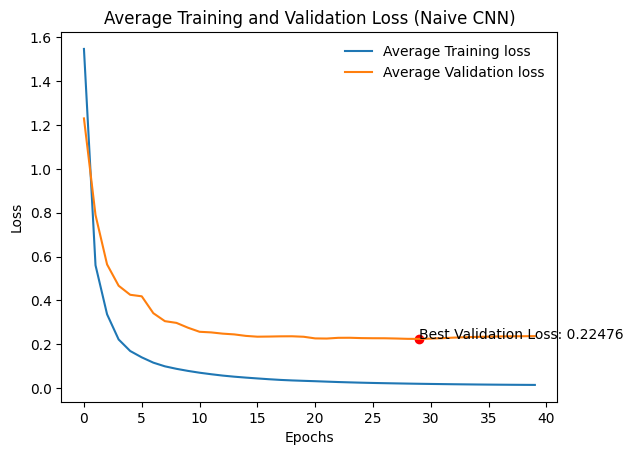

In [24]:
# accuracy overtime plot
plt.plot(avg_train_losses, label='Average Training loss')
plt.plot(avg_valid_losses, label='Average Validation loss')
plt.title('Average Training and Validation Loss (Naive CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

# plot the point of best accuracy
best_val_loss_epoch = np.argmin(avg_valid_losses)
plt.scatter(best_val_loss_epoch, early_stopping.best_val_loss, color='red')
plt.text(best_val_loss_epoch, early_stopping.best_val_loss, f'Best Validation Loss: {early_stopping.best_val_loss:.5f}')

plt.show()